In [1]:
!pip install -q pgmpy

# Belief Propagation

In this lab session you will implement the belief propagation (BP) algorithm on a factor graph using the [pgmpy library](http://www.pgmpy.org). By the end of this session you will be able to
- Create a factor graph respresenting a hidden Markov model
- Answer inference queries using the built in methods of pgmpy
- Experiment with the fundamental concepts behind probabilistic inference and message passing

## The Model

We will consider our previous Markov chain model of wheather change over time. For simpliciy, we will assume that the weather is stationary over the seven days of a week, and that it can take three different values: `sunny`, `cloudy` and `rainy`. The probability of rain or clouds after a rainy day is $0.25$ and $0.5$, respectively. A sunny day is also followed by a sunny day or a cloudy day with probabilities $0.7$ and $0.25$, respectively. Finally, if a day is cloudy, the next day will also be cloudy with probability $0.35$ or it will rain with probability $0.4$.

Let's assume that by some unfortunate reason we are not able to see the weather directly, but we can observe if someone makes use of an umbrella. This will be our observed random variable, which directly depends on the actual weather. The probability of carrying an umbrella is $0.95$ for a rainy day, $0.6$ for a cloudy day, and $0.2$ for a sunny day.  

Finally, we know that the first day of the week is sunny, cloudy, or rainy with probabilities $0.3$, $0.4$ and $0.3$, respectively.

<img src="https://raw.githubusercontent.com/guillermoim/resources/main/makov_weather.png" width=750 height=200>

<style type="text/css">@media screen and (max-width: 767px) {.tg {width: auto !important;}.tg col {width: auto !important;}.tg-wrap {overflow-x: auto;-webkit-overflow-scrolling: touch;}}</style><div class="tg-wrap"><table style="border-collapse:collapse;border-spacing:0" class="tg"><thead><tr><th style="border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal" colspan="2" rowspan="2"></th><th style="border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal" colspan="3">Today's weather</th></tr><tr><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">sunny</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">cloudy</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">rainy</th></tr></thead><tbody><tr><td style="border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:middle;word-break:normal" rowspan="3">Yesterday's weather</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">sunny</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">.7</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">.25</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">.05</td></tr><tr><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">cloudy</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">.25</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">.35</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">.4</td></tr><tr><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">rainy</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">.25</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">.5</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">.25</td></tr></tbody></table></div>


<style type="text/css">@media screen and (max-width: 767px) {.tg {width: auto !important;}.tg col {width: auto !important;}.tg-wrap {overflow-x: auto;-webkit-overflow-scrolling: touch;}}</style><div class="tg-wrap"><table style="border-collapse:collapse;border-spacing:0" class="tg"><thead><tr><th style="border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal" colspan="2" rowspan="2"></th><th style="border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal" colspan="2">Umbrella</th></tr><tr><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">true</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">false</th></tr></thead><tbody><tr><td style="border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:middle;word-break:normal" rowspan="3">Weather</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">sunny</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">.2</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">.8</td></tr><tr><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">cloudy</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">.6</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">.4</td></tr><tr><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">rainy</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">.95</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">.05</td></tr></tbody></table></div>


## Creating the Factor graph

The model is composed of $14$ random variables, $7$ corresponding to the hidden weather state, and $7$ corresponding to the binary observed variable. Let's create the factors and variables enconding the transition and observational model.

In [2]:
from pgmpy.factors.discrete import DiscreteFactor

weather = ["w1", "w2", "w3", "w4", "w5", "w6", "w7"]
umbrella = ["u1", "u2", "u3", "u4", "u5", "u6", "u7"]
variables = weather + umbrella
state_names = dict([(k, ["sunny", "cloudy", "rainy"]) for k in weather] +
                   [(k, [True, False]) for k in umbrella])

def day_transition(d1, d2): # P(d2|d1)
     return DiscreteFactor(variables=[d1, d2],
                           cardinality=[3, 3],
                           values=[0.7, 0.25, 0.05,
                                   0.25, 0.35, 0.4,
                                   0.25, 0.5, 0.25],
                           state_names=state_names)

def take_umbrella_transition(d, u): # P(u|d)
    return DiscreteFactor(variables=[d, u],
                          cardinality=[3, 2],
                          values=[0.2, 0.8,
                                  0.6, 0.4,
                                  0.95, 0.05],
                          state_names=state_names)

p = dict()
p["w1"] = DiscreteFactor(variables=["w1"],
                         cardinality=[3],
                         values=[0.3, 0.4, 0.3],
                         state_names=state_names)

p["w2|w1"] = day_transition("w1", "w2")
p["w3|w2"] = day_transition("w2", "w3")
p["w4|w3"] = day_transition("w3", "w4")
p["w5|w4"] = day_transition("w4", "w5")
p["w6|w5"] = day_transition("w5", "w6")
p["w7|w6"] = day_transition("w6", "w7")

p["u1|w1"] = take_umbrella_transition("w1", "u1")
p["u2|w2"] = take_umbrella_transition("w2", "u2")
p["u3|w3"] = take_umbrella_transition("w3", "u3")
p["u4|w4"] = take_umbrella_transition("w4", "u4")
p["u5|w5"] = take_umbrella_transition("w5", "u5")
p["u6|w6"] = take_umbrella_transition("w6", "u6")
p["u7|w7"] = take_umbrella_transition("w7", "u7")

print(p["w2|w1"])
print(p["u1|w1"])

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


+------------+------------+--------------+
| w1         | w2         |   phi(w1,w2) |
+============+============+==============+
| w1(sunny)  | w2(sunny)  |       0.7000 |
+------------+------------+--------------+
| w1(sunny)  | w2(cloudy) |       0.2500 |
+------------+------------+--------------+
| w1(sunny)  | w2(rainy)  |       0.0500 |
+------------+------------+--------------+
| w1(cloudy) | w2(sunny)  |       0.2500 |
+------------+------------+--------------+
| w1(cloudy) | w2(cloudy) |       0.3500 |
+------------+------------+--------------+
| w1(cloudy) | w2(rainy)  |       0.4000 |
+------------+------------+--------------+
| w1(rainy)  | w2(sunny)  |       0.2500 |
+------------+------------+--------------+
| w1(rainy)  | w2(cloudy) |       0.5000 |
+------------+------------+--------------+
| w1(rainy)  | w2(rainy)  |       0.2500 |
+------------+------------+--------------+
+------------+-----------+--------------+
| w1         | u1        |   phi(w1,u1) |
+============

In [3]:
print(p['w7|w6'])

+------------+------------+--------------+
| w6         | w7         |   phi(w6,w7) |
+============+============+==============+
| w6(sunny)  | w7(sunny)  |       0.7000 |
+------------+------------+--------------+
| w6(sunny)  | w7(cloudy) |       0.2500 |
+------------+------------+--------------+
| w6(sunny)  | w7(rainy)  |       0.0500 |
+------------+------------+--------------+
| w6(cloudy) | w7(sunny)  |       0.2500 |
+------------+------------+--------------+
| w6(cloudy) | w7(cloudy) |       0.3500 |
+------------+------------+--------------+
| w6(cloudy) | w7(rainy)  |       0.4000 |
+------------+------------+--------------+
| w6(rainy)  | w7(sunny)  |       0.2500 |
+------------+------------+--------------+
| w6(rainy)  | w7(cloudy) |       0.5000 |
+------------+------------+--------------+
| w6(rainy)  | w7(rainy)  |       0.2500 |
+------------+------------+--------------+


Now, let's build the model using the ```FactorGraph``` class. To do so, we first need to add all variable nodes with ```add_nodes_from```. Then, we add each factor ```f``` to the graph with```add_factors(f)``` and, for each of its variables ```v``` (available in ```f.variables```), we create an edge between ```f``` and ```v```  with ```add_edge(f,v)```. Finally, we verify that the factor graph is correct with the ```check_model``` method.

In [4]:
from pgmpy.models import FactorGraph
G = FactorGraph()

assert set(variables) == set([v for f in p.values() for v in f.variables])

G.add_nodes_from(variables)
for f in p.values():
    G.add_factors(f)
    for v in f.variables:
        G.add_edge(v,f)

print("Model is ok: ", G.check_model())

Model is ok:  True


In [5]:
len(G.factors)

14

In [6]:
def edges_of(graph, start, papa_node = None):
  neighbors = graph.neighbors(start)
  for neighbor in neighbors:
    if neighbor is not papa_node:
      print(f'\33[91m{start!r}\33[0m is neighbor of \33[94m{neighbor!r}\33[0m')
      edges_of(graph, neighbor, papa_node=start)

print(len(G.nodes))


28


## Running Inference Queries

We will use now some methods implemented in `pgmpy` that perform exact inference.
Consider the following queries:

1. We observe that on Thursday and Friday the umbrella is being used. What is the weather prediction for Saturday?
2. What is the weather prediction for Sunday, with the same observations?
3. What is the weather prediction for Sunday if, instead, we observe that the umbrella is NOT being used on Thursday and Friday?
4. What is the most likely weather sequence for Monday and Tuesday, if we observed that the umbrella has been used both days?


Answer the three previous queries using the `query` method of the `BeliefPropagation` class:
```python
    def query(self, variables, evidence=None, joint=True, show_progress=True):
        """
        Query method using belief propagation.

        Parameters
        ----------
        variables: list
            list of variables for which you want to compute the probability

        evidence: dict
            a dict key, value pair as {var: state_of_var_observed}
            None if no evidence

        joint: boolean
            If True, returns a Joint Distribution over `variables`.
            If False, returns a dict of distributions over each of the `variables`
```

**You will need to normalize the output.** The result of the query itself has a ```.normalize()``` method.

In [7]:
print(p["w1"])

+------------+-----------+
| w1         |   phi(w1) |
+============+===========+
| w1(sunny)  |    0.3000 |
+------------+-----------+
| w1(cloudy) |    0.4000 |
+------------+-----------+
| w1(rainy)  |    0.3000 |
+------------+-----------+


In [8]:
from pgmpy.inference import BeliefPropagation
bp = BeliefPropagation(G)

q = bp.query(variables=['w6'],
             evidence={"u4":True,"u5":True})

print('before normalize', q)

q.normalize()
print("Prob SAT given THU and FRI umbrella")
print(q)

q = bp.query(variables=['w7'],
             evidence={"u4":True,"u5":True})
q.normalize()
print("Prob SUN given THU and FRI umbrella")
print(q)

q = bp.query(variables=['w7'],
             evidence={"u4":False,"u5":False})
q.normalize()
print("Prob SUN given THU and FRI NOT umbrella")
print(q)

q = bp.query(variables=['w1','w2'],
             evidence={"u1":True,"u2":True})
q.normalize()
print("Prob MON, TUE given umbrella")
print(q)

before normalize +------------+-----------+
| w6         |   phi(w6) |
+============+===========+
| w6(sunny)  |    0.3025 |
+------------+-----------+
| w6(cloudy) |    0.4080 |
+------------+-----------+
| w6(rainy)  |    0.2895 |
+------------+-----------+
Prob SAT given THU and FRI umbrella
+------------+-----------+
| w6         |   phi(w6) |
+============+===========+
| w6(sunny)  |    0.3025 |
+------------+-----------+
| w6(cloudy) |    0.4080 |
+------------+-----------+
| w6(rainy)  |    0.2895 |
+------------+-----------+
Prob SUN given THU and FRI umbrella
+------------+-----------+
| w7         |   phi(w7) |
+============+===========+
| w7(sunny)  |    0.3861 |
+------------+-----------+
| w7(cloudy) |    0.3632 |
+------------+-----------+
| w7(rainy)  |    0.2507 |
+------------+-----------+
Prob SUN given THU and FRI NOT umbrella
+------------+-----------+
| w7         |   phi(w7) |
+============+===========+
| w7(sunny)  |    0.5225 |
+------------+-----------+
| w7(cl

In [9]:
q = bp.query(variables=['w1','w5'],
             evidence={"u1":True,"u5":True})
q.normalize()
print("Prob MON, TUE given umbrella")
print(q)

Prob MON, TUE given umbrella
+------------+------------+--------------+
| w1         | w5         |   phi(w1,w5) |
+============+============+==============+
| w1(sunny)  | w5(sunny)  |       0.0196 |
+------------+------------+--------------+
| w1(sunny)  | w5(cloudy) |       0.0402 |
+------------+------------+--------------+
| w1(sunny)  | w5(rainy)  |       0.0383 |
+------------+------------+--------------+
| w1(cloudy) | w5(sunny)  |       0.0715 |
+------------+------------+--------------+
| w1(cloudy) | w5(cloudy) |       0.1693 |
+------------+------------+--------------+
| w1(cloudy) | w5(rainy)  |       0.1715 |
+------------+------------+--------------+
| w1(rainy)  | w5(sunny)  |       0.0849 |
+------------+------------+--------------+
| w1(rainy)  | w5(cloudy) |       0.2007 |
+------------+------------+--------------+
| w1(rainy)  | w5(rainy)  |       0.2041 |
+------------+------------+--------------+


## Implementing Belief Propagation

Implement your own Belief Propagation algorithm by filling in the provided code skeleton. You will need to provide the code to:
* Add the evidence factors
* Initialize a factor-to-variable message `f->v` and a variable-to-factor message `v->f` for each edge in the graph
* Update messages of each type
* Perform message passing using the collect_evidence and distribute_evidence algorithms
* Compute the marginal using the messages

See function comments for more details. Each comment line ```#IMPLEMENT``` is to be replaced with as many lines of code as you need. Method definitions should remain unchanged.

In [10]:
from functools import reduce
import operator
from collections import defaultdict
from copy import deepcopy

def prod(iterable):
    """Helper function to obtain the product of all the items in the iterable
    given as input"""
    return reduce(operator.mul, iterable, 1)

class MyBeliefPropagation:
    def __init__(self, factor_graph):
        assert factor_graph.check_model()
        self.original_graph = factor_graph
        self.variables = factor_graph.get_variable_nodes()

        self.state_names = dict()
        for f in self.original_graph.factors:
            self.state_names.update(f.state_names)

    def factor_ones(self, v):
        """
        Returns a DiscreteFactor for variable v with all ones.
        """
        card = len(self.state_names[v])
        return DiscreteFactor(variables=[v],
                              cardinality=[card],
                              values=[1]*card,
                              state_names=self.state_names)

    def initialize_messages(self):
        """
        This function creates, for each edge factor-variable, two messages: m(f->v) and
        m(v->f). It initiliazies each message as a DiscreteFactor with all ones. It stores all
        the messages in a dict of dict. Keys of both dicts are either factors or variables.
        Messages are indexed as messages[to][from]. For example, m(x->y) is in messages[y][x].
        It's done this way because it will be useful to get all messages that go to a variable
        or a factor.
        """
        self.messages = defaultdict(dict)
        for f in self.working_graph.get_factors():
            for v in f.variables:
                self.messages[v][f] = self.factor_ones(v)
                self.messages[f][v] = self.factor_ones(v)

    def factor_to_variable(self, f, v):
        """
        Computes message m from factor to variable.
        It computes it from all messages from all
        other variables to the factor (i.e. all variables connected the factor except v).
        Returns message m.
        """
        assert v in self.variables and f in self.working_graph.factors
        messages_to_f = list(self.messages[f].values())
        messages_to_f.remove(self.messages[f][v]) # all except the one from variable v

        m = f * prod(messages_to_f)
        other_vars = set(m.variables) - set([v])
        m.marginalize(other_vars)
        return m

    def variable_to_factor(self, v, f):
        """
        Computes message m from variable to factor.
        It computes it from all messages from all
        other factors to the variable (i.e. all factors connected the variable except f).
        Returns message m.
        """
        assert v in self.variables and f in self.working_graph.factors
        messages_to_v = list(self.messages[v].values())
        messages_to_v.remove(self.messages[v][f]) # all except the one from factor f
        if len(messages_to_v) == 0: # No neighbors, return 1 (or return None and do not update)
            return self.factor_ones(v)
        m = prod(messages_to_v)
        return m

    def get_evidence_factors(self, evidence):
        """
        For each evidence variable v, create a factor with p(v=e)=1. Receives a dict of
        evidence, where keys are variables and values are variable states. Returns a list of
        DiscreteFactor.
        """
        # For each factor that involves variable v, add another factor with p(v=value)=1.
        # Returns a list of evidence factors.
        evidence_factors = []

        for variable, value in evidence.items():
            i = self.state_names[variable].index(value)
            values = [0]*len(self.state_names[variable])
            values[i] = 1.0
            ef = DiscreteFactor(variables=[variable],
                                cardinality=[len(values)],
                                values=values,
                                state_names=self.state_names)
            evidence_factors.append(ef)
        return evidence_factors

    def update(self, m_to, m_from):
        """
        Performs an update of a message depending on whether it is variable-to-factor or
        factor-to-variable.
        """
        if m_from in self.variables:
            assert m_to in self.working_graph.factors, f"m_from: {m_from}\nm_to: {m_to}"
            self.messages[m_to][m_from] = self.variable_to_factor(m_from, m_to)
        else:
            assert m_from in self.working_graph.factors and m_to in self.variables, f"m_from: {m_from}\nm_to: {m_to}"
            self.messages[m_to][m_from] = self.factor_to_variable(m_from, m_to)

    def collect_evidence(self, node, parent=None):
        """
        Passes messages from the leaves to the root of the tree.
        The parent argument is used to avoid an infinite recursion.
        """
        for child in self.working_graph.neighbors(node):
            if child is not parent:
                self.update(node, self.collect_evidence(child, parent=node))
        return node

    def distribute_evidence(self, node, parent=None):
        """
        Passes messages from the root to the leaves of the tree.
        The parent argument is used to avoid an infinite recursion.
        """
        for child in self.working_graph.neighbors(node):
            if child is not parent:
                self.update(child, node)
                self.distribute_evidence(child, parent=node)

    def set_evidence(self, evidence):
        """
        Generates a new graph with the evidence factors
        evidence (keys: variables, values: states)
        """
        evidence_factors = self.get_evidence_factors(evidence)
        self.working_graph = self.original_graph.copy()
        for f in evidence_factors:
            self.working_graph.add_factors(f)
            for v in f.variables:
                self.working_graph.add_edge(v,f)
        self.bp_done = False

    def run_bp(self, root):
        """
        After initializing the messages, this function performs Belief Propagation
        using collect_evidence and distribute_evidence from the given root node.
        """
        assert root in self.variables, "Variable not in the model"
        self.initialize_messages()
        print('Wroking graph', self.working_graph.check_model())
        self.collect_evidence(root)
        self.distribute_evidence(root)
        self.bp_done = True

    def get_marginal(self, variable):
        """
        To be used after run_bp. Returns p(variable | evidence) unnormalized.
        """
        assert self.bp_done, "First run BP!"
        return prod(self.messages[variable].values())

    def get_marginal_subset(self, variables):
        assert isinstance(variables, list), "variables should be a list"
        assert self.bp_done, "First run BP!"

        # Initialize common_factors to None
        common_factors = None

        # Loop through each variable in the list
        for var in variables:
            # Get factors connected to the current variable
            factors_connected_to_var = set(self.messages[var].keys())

            # If common_factors is None, update it with factors_connected_to_var
            if common_factors is None:
                common_factors = factors_connected_to_var
            else:
                # Take the intersection of common_factors and factors_connected_to_var
                common_factors = common_factors.intersection(factors_connected_to_var)

        # If there is no common factor we can say that this variables are not connected
        if common_factors is None or len(common_factors) == 0:
                raise ValueError("No common factors found among the provided variables, therefore they are not connected.")    
        
        fact = common_factors.pop()
        
        messages_to_f = list(self.messages[fact].values())
        m = fact * prod(messages_to_f)
        
        other_vars = set(m.variables) - set(variables)
        m.marginalize(other_vars)
        
        return m


Check that your implementation produces the same results for the first three queries P(w7|u4=t,u5=t), P(w7|u4=t,u5=t), and P(w6|u4=f,u5=f) as the ones given by the `BeliefPropagation` class. Do you need to run BP each time? Justify your answer.

In [11]:
q = bp.query(variables=['w6','w7'],
             evidence={'u6':True, 'u7':True})
q.normalize()
print("Prob MON, TUE given umbrella")
print(q)

Prob MON, TUE given umbrella
+------------+------------+--------------+
| w6         | w7         |   phi(w6,w7) |
+============+============+==============+
| w6(sunny)  | w7(sunny)  |       0.0455 |
+------------+------------+--------------+
| w6(sunny)  | w7(cloudy) |       0.0488 |
+------------+------------+--------------+
| w6(sunny)  | w7(rainy)  |       0.0154 |
+------------+------------+--------------+
| w6(cloudy) | w7(sunny)  |       0.0364 |
+------------+------------+--------------+
| w6(cloudy) | w7(cloudy) |       0.1529 |
+------------+------------+--------------+
| w6(cloudy) | w7(rainy)  |       0.2767 |
+------------+------------+--------------+
| w6(rainy)  | w7(sunny)  |       0.0361 |
+------------+------------+--------------+
| w6(rainy)  | w7(cloudy) |       0.2166 |
+------------+------------+--------------+
| w6(rainy)  | w7(rainy)  |       0.1715 |
+------------+------------+--------------+


In [12]:
my_bp = MyBeliefPropagation(G)

print("Prob SAT given THU and FRI umbrella")
my_bp.set_evidence({'u6':True, 'u7':True})
my_bp.run_bp(root="w6")

res = my_bp.get_marginal_subset(["w6","w7"])
res.normalize(inplace=True)
print(res)

Prob SAT given THU and FRI umbrella
Wroking graph True
+------------+------------+--------------+
| w6         | w7         |   phi(w6,w7) |
+============+============+==============+
| w6(sunny)  | w7(sunny)  |       0.0455 |
+------------+------------+--------------+
| w6(sunny)  | w7(cloudy) |       0.0488 |
+------------+------------+--------------+
| w6(sunny)  | w7(rainy)  |       0.0154 |
+------------+------------+--------------+
| w6(cloudy) | w7(sunny)  |       0.0364 |
+------------+------------+--------------+
| w6(cloudy) | w7(cloudy) |       0.1529 |
+------------+------------+--------------+
| w6(cloudy) | w7(rainy)  |       0.2767 |
+------------+------------+--------------+
| w6(rainy)  | w7(sunny)  |       0.0361 |
+------------+------------+--------------+
| w6(rainy)  | w7(cloudy) |       0.2166 |
+------------+------------+--------------+
| w6(rainy)  | w7(rainy)  |       0.1715 |
+------------+------------+--------------+


In [13]:
q = bp.query(variables=['w1','w2'],
             evidence={'u1':True, 'u2':True})
q.normalize()
print("Prob MON, TUE given umbrella")
print(q)

Prob MON, TUE given umbrella
+------------+------------+--------------+
| w1         | w2         |   phi(w1,w2) |
+============+============+==============+
| w1(sunny)  | w2(sunny)  |       0.0246 |
+------------+------------+--------------+
| w1(sunny)  | w2(cloudy) |       0.0264 |
+------------+------------+--------------+
| w1(sunny)  | w2(rainy)  |       0.0084 |
+------------+------------+--------------+
| w1(cloudy) | w2(sunny)  |       0.0352 |
+------------+------------+--------------+
| w1(cloudy) | w2(cloudy) |       0.1477 |
+------------+------------+--------------+
| w1(cloudy) | w2(rainy)  |       0.2672 |
+------------+------------+--------------+
| w1(rainy)  | w2(sunny)  |       0.0418 |
+------------+------------+--------------+
| w1(rainy)  | w2(cloudy) |       0.2505 |
+------------+------------+--------------+
| w1(rainy)  | w2(rainy)  |       0.1983 |
+------------+------------+--------------+


In [14]:
my_bp = MyBeliefPropagation(G)

print("Prob SAT given THU and FRI umbrella")
my_bp.set_evidence({'u1':True, 'u2':True})
my_bp.run_bp(root="w1")

res = my_bp.get_marginal_subset(["w1","w2"])
res.normalize(inplace=True)
print(res)

Prob SAT given THU and FRI umbrella
Wroking graph True
+------------+------------+--------------+
| w2         | w1         |   phi(w2,w1) |
+============+============+==============+
| w2(sunny)  | w1(sunny)  |       0.0246 |
+------------+------------+--------------+
| w2(sunny)  | w1(cloudy) |       0.0352 |
+------------+------------+--------------+
| w2(sunny)  | w1(rainy)  |       0.0418 |
+------------+------------+--------------+
| w2(cloudy) | w1(sunny)  |       0.0264 |
+------------+------------+--------------+
| w2(cloudy) | w1(cloudy) |       0.1477 |
+------------+------------+--------------+
| w2(cloudy) | w1(rainy)  |       0.2505 |
+------------+------------+--------------+
| w2(rainy)  | w1(sunny)  |       0.0084 |
+------------+------------+--------------+
| w2(rainy)  | w1(cloudy) |       0.2672 |
+------------+------------+--------------+
| w2(rainy)  | w1(rainy)  |       0.1983 |
+------------+------------+--------------+


Use BP to compute the fourth query P(w1,w2|u1=t,u2=t). Note that we cannot do it with the ```get_marginal``` method as it is now. Define a method ```get_marginal_subset``` that receives a list of variables as input and, if they are connected, returns the marginal of the subset. Otherwise, throw an error. Check your result with the one produced by the `BeliefPropagation` class.

## Another Graph more simple

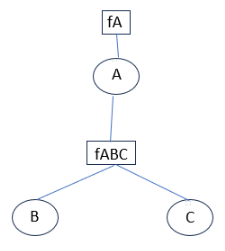

In [15]:
from pgmpy.models import FactorGraph
from pgmpy.factors.discrete import DiscreteFactor

variables = ["a", "b", "c"]
p = dict()
p["a"] = DiscreteFactor(variables=["a"],
                         cardinality=[2],
                         values=[0.5, 0.5]
                         )
p["b|a"] = DiscreteFactor(variables=["a", "b"],
                           cardinality=[2,2],
                           values=[0.7, 0.3,
                                   0.3, 0.7])
p["c|a"] = DiscreteFactor(variables=["a", "c"],
                           cardinality=[2,2],
                           values=[0.7, 0.3,
                                   0.3, 0.7])
# Crear el grafo de factores
FG = FactorGraph()

# Agregar los nodos al grafo
FG.add_nodes_from(variables)

# Crear factores
factor_A = p["a"]
factor_ABC = p["b|a"] * p["c|a"]

# Agregar factores
FG.add_factors(factor_A)
FG.add_factors(factor_ABC)

# Enlazar nodos
FG.add_edge("a", factor_A)
FG.add_edge("a", factor_ABC)
FG.add_edge("b", factor_ABC)
FG.add_edge("c", factor_ABC)


In [16]:
## Checking
from pgmpy.inference import BeliefPropagation
bp = BeliefPropagation(FG)

q = bp.query(variables=['a'])
q.normalize()  # IMPORTANT!
print("Prob a")
print(q)

Prob a
+------+----------+
| a    |   phi(a) |
+======+==========+
| a(0) |   0.5000 |
+------+----------+
| a(1) |   0.5000 |
+------+----------+


In [17]:
q = bp.query(variables=['a'], evidence={"b":True})
q.normalize()
print("Prob a|b=T")
print(q)

Prob a|b=T
+------+----------+
| a    |   phi(a) |
+======+==========+
| a(0) |   0.3000 |
+------+----------+
| a(1) |   0.7000 |
+------+----------+


In [18]:
q = bp.query(variables=["a","b"])
q.normalize()
print("Prob(a,b) Joint")
print(q)

Prob(a,b) Joint
+------+------+------------+
| a    | b    |   phi(a,b) |
+======+======+============+
| a(0) | b(0) |     0.3500 |
+------+------+------------+
| a(0) | b(1) |     0.1500 |
+------+------+------------+
| a(1) | b(0) |     0.1500 |
+------+------+------------+
| a(1) | b(1) |     0.3500 |
+------+------+------------+


#### Now with our implementation

In [19]:
my_bp = MyBeliefPropagation(FG)

print("Prob A")

# RECORDAR SEMPRE SETEJAR LA EVIDENCE, PER TEMA DE WORKING GRAPH
my_bp.set_evidence({})
my_bp.run_bp(root="a")
res = my_bp.get_marginal("a")
res.normalize(inplace=True)
print(res)

Prob A
Wroking graph True
+------+----------+
| a    |   phi(a) |
+======+==========+
| a(0) |   0.5000 |
+------+----------+
| a(1) |   0.5000 |
+------+----------+


In [20]:
my_bp = MyBeliefPropagation(FG)
my_bp.set_evidence({})
my_bp.run_bp(root="a")
res = my_bp.get_marginal_subset(["a","b"])
res.normalize(inplace=True)
print('JOINT --> p[a,b]')
print(res)

Wroking graph True
JOINT --> p[a,b]
+------+------+------------+
| b    | a    |   phi(b,a) |
+======+======+============+
| b(0) | a(0) |     0.3500 |
+------+------+------------+
| b(0) | a(1) |     0.1500 |
+------+------+------------+
| b(1) | a(0) |     0.1500 |
+------+------+------------+
| b(1) | a(1) |     0.3500 |
+------+------+------------+


In [21]:
my_bp = MyBeliefPropagation(FG)
my_bp.set_evidence({"b":True})
my_bp.run_bp(root="a")
res = my_bp.get_marginal_subset(["a"])
res.normalize(inplace=True)
print('When knowing B --> p[a|b]')
print(res)

Wroking graph True
When knowing B --> p[a|b]
+------+----------+
| a    |   phi(a) |
+======+==========+
| a(0) |   0.3000 |
+------+----------+
| a(1) |   0.7000 |
+------+----------+


In [22]:
my_bp = MyBeliefPropagation(FG)
my_bp.set_evidence({"c":True})
my_bp.run_bp(root="a")
res = my_bp.get_marginal_subset(["a","b"])
res.normalize(inplace=True)
print('When knowing C --> p[a,b|c]')
print(res)

Wroking graph True
When knowing C --> p[a,b|c]
+------+------+------------+
| b    | a    |   phi(b,a) |
+======+======+============+
| b(0) | a(0) |     0.2100 |
+------+------+------------+
| b(0) | a(1) |     0.2100 |
+------+------+------------+
| b(1) | a(0) |     0.0900 |
+------+------+------------+
| b(1) | a(1) |     0.4900 |
+------+------+------------+


In [23]:
my_bp = MyBeliefPropagation(FG)
my_bp.set_evidence({})
my_bp.run_bp(root="a")
res = my_bp.get_marginal_subset(["a","b","c"])
res.normalize(inplace=True)
print('Joint --> p[a,b,c]')
print(res)

Wroking graph True
Joint --> p[a,b,c]
+------+------+------+--------------+
| b    | a    | c    |   phi(b,a,c) |
+======+======+======+==============+
| b(0) | a(0) | c(0) |       0.2450 |
+------+------+------+--------------+
| b(0) | a(0) | c(1) |       0.1050 |
+------+------+------+--------------+
| b(0) | a(1) | c(0) |       0.0450 |
+------+------+------+--------------+
| b(0) | a(1) | c(1) |       0.1050 |
+------+------+------+--------------+
| b(1) | a(0) | c(0) |       0.1050 |
+------+------+------+--------------+
| b(1) | a(0) | c(1) |       0.0450 |
+------+------+------+--------------+
| b(1) | a(1) | c(0) |       0.1050 |
+------+------+------+--------------+
| b(1) | a(1) | c(1) |       0.2450 |
+------+------+------+--------------+
